In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import dask
import dask.distributed
from itertools import product
from joblib import Parallel, delayed
from collections import defaultdict

import common
import vcm
import fv3viz

In [2]:
client = dask.distributed.Client()

/home/andrep/miniconda3/envs/fv3net/lib/python3.8/site-packages/distributed/node.py:183: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 40849 instead
  warnings.warn(


Make it faster

In [3]:
base = "zc-emu-seed{seed}-prognostic-30d-v2-{run_type}"
run_types = ["online", "offline"]
seeds = [f"{i:d}" for i in range(1,6)]
args =  list(product(seeds, run_types))

In [4]:
group_names = []

for seed, run_type in args:

    group = base.format(seed=seed, run_type=run_type)
    group_names.append(group)

In [5]:
def prepare_for_dask(group):
    data = common.open_group(group)

    # data is already on pressure levels
    key = "cloud_water_mixing_ratio"
    cloud = data[key].where(data.lat < -60).isel(tile=5)
    delp = data.delp.isel(tile=5)
    area = data.area.isel(tile=5)

    integrated = vcm.mass_integrate(cloud, delp, dim="z")
    averaged = vcm.weighted_average(integrated, area, dims=["x", "y"])

    return averaged


In [6]:
jobs = [delayed(prepare_for_dask)(group) for group in group_names]
results = Parallel(n_jobs=12)(jobs)
group_zarr_map = {
    group: result for group, result in zip(group_names, results)
}

In [7]:
@common.memoize_xarray_out
def get_antarctic_cloud_seeds(group):
    return group_zarr_map[group].load()

In [8]:
cloud_results = [
    get_antarctic_cloud_seeds(group) for group in group_zarr_map.keys()
]

In [19]:
def gather(field_key, args, results, drop_time=False):
    out = defaultdict(list)

    for i, ds in enumerate(results):
        month, run_type = args[i]
        if drop_time:
            ds = ds.drop_vars(["time"])
        out[run_type].append(ds["__xarray_dataarray_variable__"])
        print(list(ds.data_vars))
    
    out["offline"] = xr.concat(out["offline"], dim="seed")
    out["online"] = xr.concat(out["online"], dim="seed")
    
    return out

In [20]:
cloud = gather("cloud_water_mixing_ratio", args, cloud_results, drop_time=False)

['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']
['__xarray_dataarray_variable__']


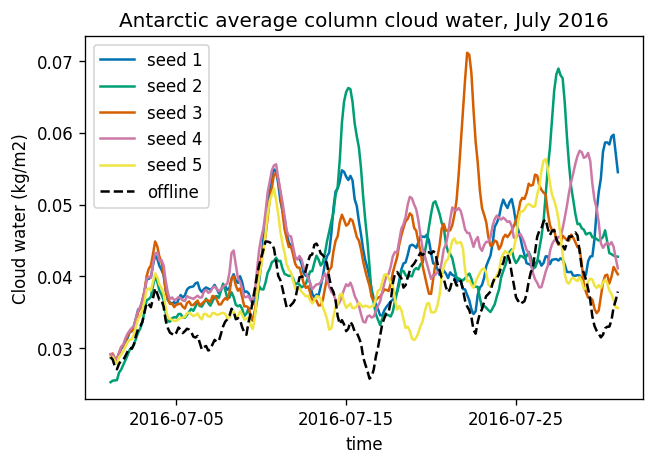

In [25]:
fig, ax = plt.subplots(dpi=120)
for i in range(5):
    l, = cloud["online"].isel(seed=i).plot(ax=ax, x="time", label=f"seed {i+1}")

cloud["offline"].isel(seed=i).plot(ax=ax, x="time", linestyle="--", color="k", label="offline")
plt.title("Antarctic average column cloud water, July 2016")
plt.legend()
plt.ylabel("Cloud water (kg/m2)")
plt.show()

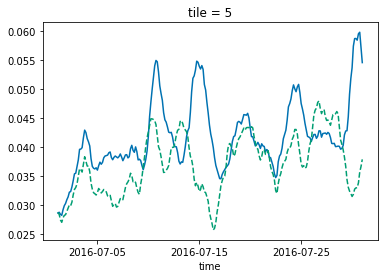

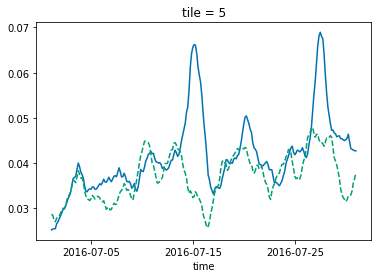

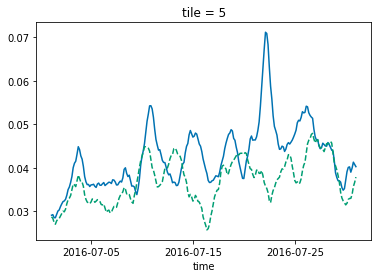

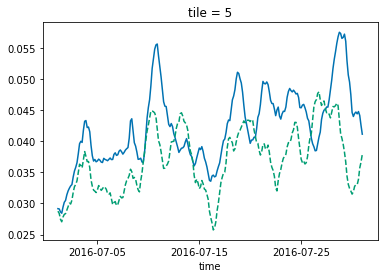

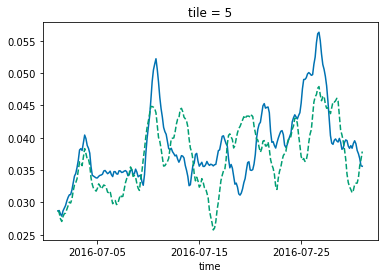

In [16]:

for i in range(5):
    cloud["online"].isel(seed=i).plot(x="time")
    cloud["offline"].isel(seed=i).plot(x="time", linestyle="--")
    plt.show()

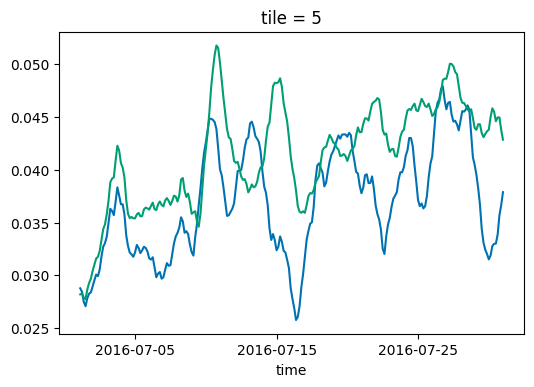

In [17]:
fig, ax = plt.subplots(dpi=100)
cloud["offline"].mean(dim="seed").plot(ax=ax, x="time")
cloud["online"].mean(dim="seed").plot(ax=ax, x="time")
plt.show()